# Syllables Analysis & Derégnaucourt replication

This notebook contains statistical analyses done by Derégnaucourt et al. (2005). Our goal is to reproduce the results of this paper.

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import birdsonganalysis as bsa
from copy import deepcopy
from os.path import join, isdir, exists
import json
import pandas as pd
import pickle
from scipy.io import wavfile
from syllable_cluster import *

from ipywidgets.widgets import FloatProgress
from IPython.display import display

import sys

sys.path.append('../model')

from song_model import SongModel

sns.set_palette('colorblind')
%matplotlib inline

Extract the data from all the bird in the simulation.

In [2]:
import itertools
progress = FloatProgress(min=0, max=1)
display(progress)
main_path = '../model/res/diversity_weight/seed{}+big_ba+3_conc+3_day_conc+{}_diversity_weight+small_bloat_weight/'
all_dat = []

for seed, div in itertools.product(range(40), [10, 15, 2, 3]):
    if not isdir(main_path.format(seed, div)) or not exists(join(main_path.format(seed, div), 'data.pkl')):
        continue
    path = main_path.format(seed, div)
    cur_dat = syllables_from_run(path, force=False, progress=progress)
    cur_dat['bird'] = seed * 1000 + div
    cur_dat['div'] = div
    all_dat.append(cur_dat)
    seed += 1
all_dat = pd.concat(all_dat)

sr, tutor = wavfile.read(join(main_path.format(10, 1), 'tutor.wav'))
tutor_syllables = extract_syllables_statistics(tutor)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [3]:
pad = 20


In [4]:
all_dat.keys()

Index(['beg', 'comb', 'day', 'end', 'isong', 'isyb', 'length', 'mam',
       'mamplitude', 'mentropy', 'mfm', 'mgoodness', 'moment', 'mpitch', 'vam',
       'vamplitude', 'ventropy', 'vfm', 'vgoodness', 'vpitch', 'run_name',
       'bird', 'div'],
      dtype='object')

# Study dynamics of syllable progression

In [5]:
all_dat['bird'].unique()

array([   10,    15,     2,     3,  1010,  4010,  4015,  4002,  4003,
        9010, 10010, 10015, 10002, 10003])

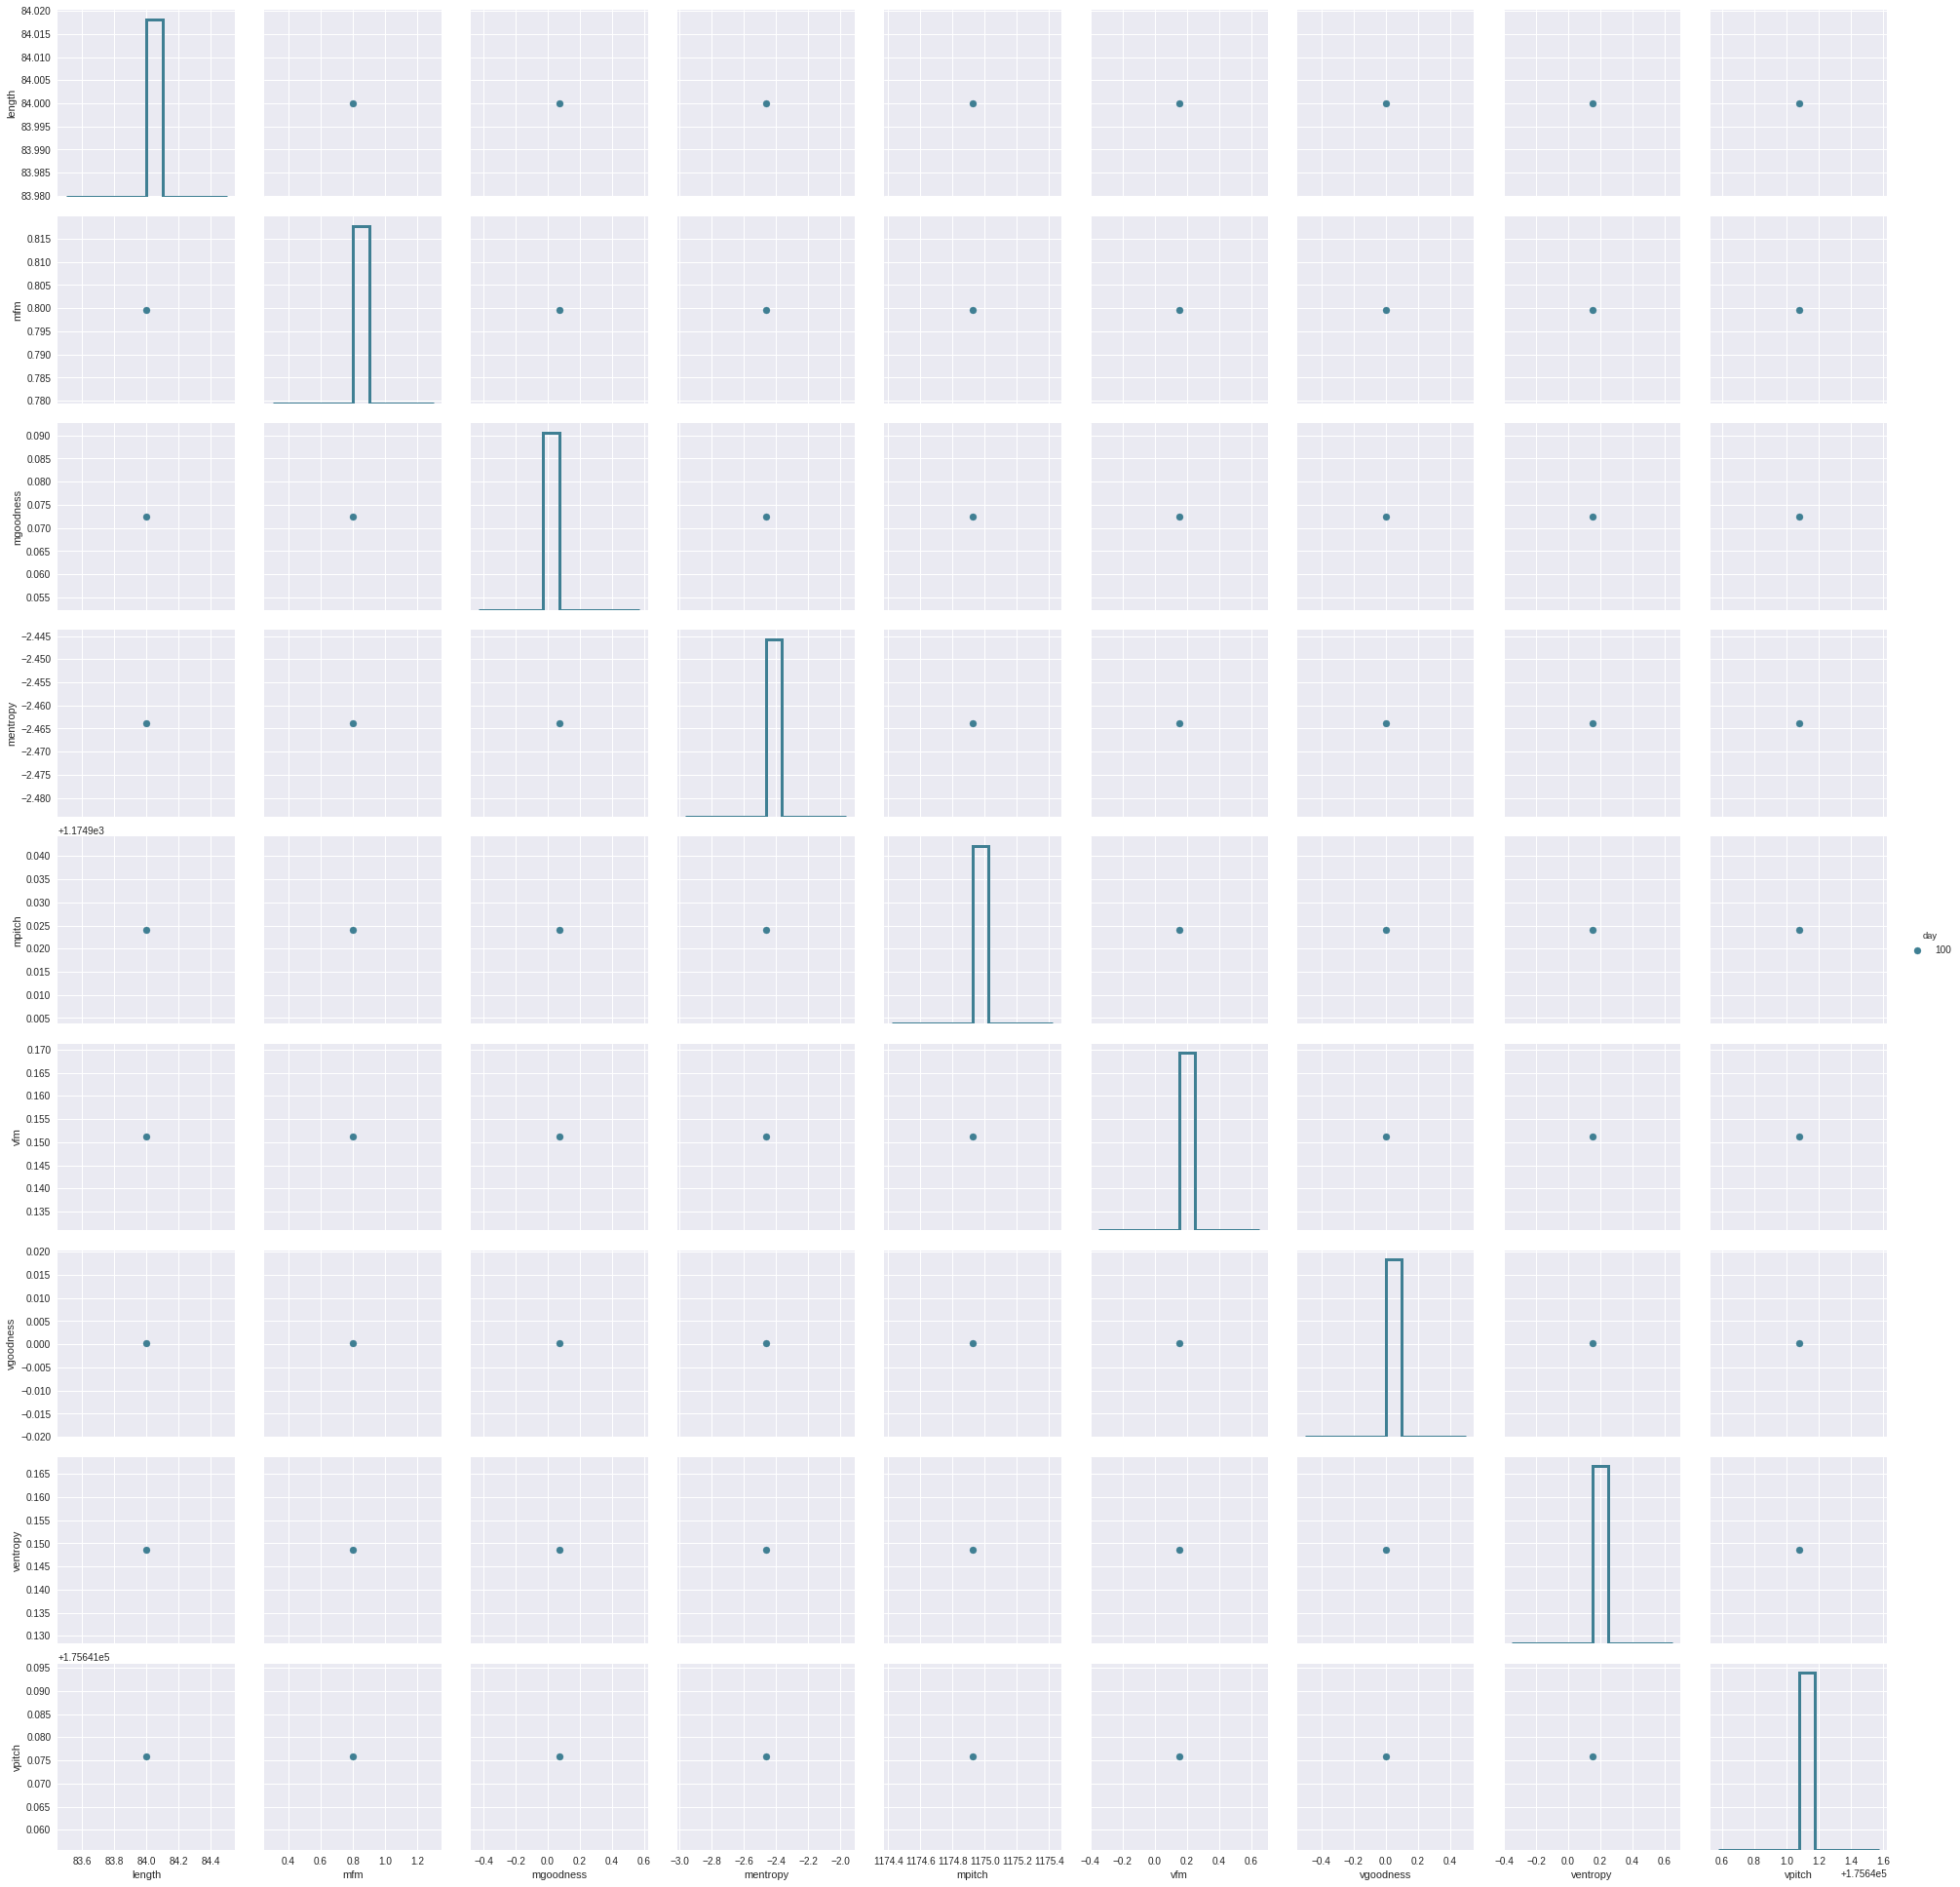

In [6]:
beg = tutor_syllables[0]['beg'] - pad
end = tutor_syllables[0]['end'] + pad
plot_dat = all_dat.query("((bird == {bird}) and (moment == 'evening') and ( \
                         (beg > {beg} and end < {end}) and day % 5 == 4))".format(
    bird=8002,
    beg=tutor_syllables[0]['beg'] - pad,
    end=tutor_syllables[0]['end'] + pad
))
tutor_df = pd.DataFrame(tutor_syllables)
tutor_df['day'] = 100
plot_dat = pd.concat((plot_dat, tutor_df.query("beg > {beg} and end < {end}".format(beg=beg, end=end))))

g = sns.PairGrid(plot_dat, hue="day", hue_kws={'marker': ['o'] * (50//5) + ['*']},
                 vars=['length', 'mfm', 'mgoodness', 'mentropy', 'mpitch',
                                            'vfm', 'vgoodness', 'ventropy', 'vpitch'], size=3, palette=sns.diverging_palette(220, 20, n=5))
g.map_diag(plt.hist, histtype="step", linewidth=3)
g.map_offdiag(plt.scatter, alpha=1)
#g.map_offdiag(sns.kdeplot, alpha=0.3)
g.add_legend()


/home/ecoffet/.virtualenvs/birdsongs/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


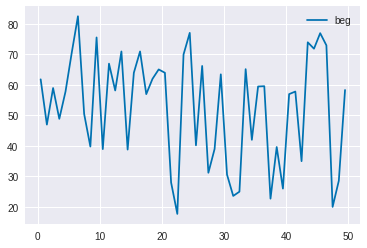

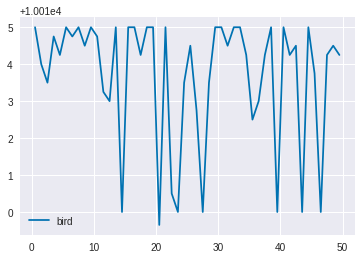

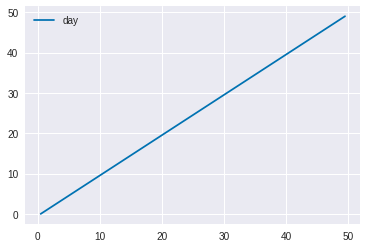

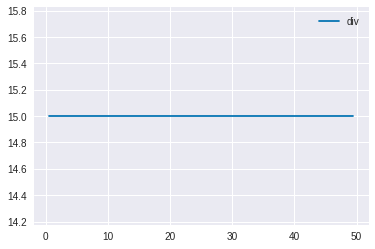

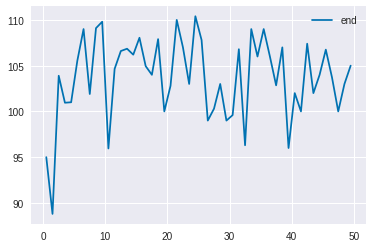

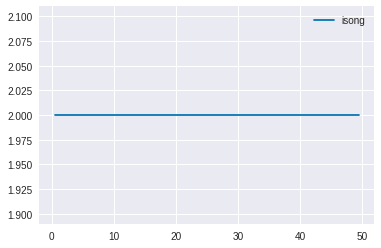

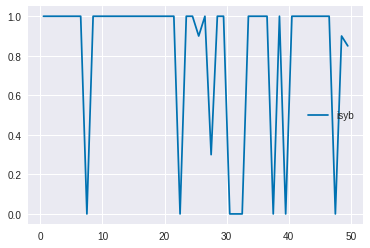

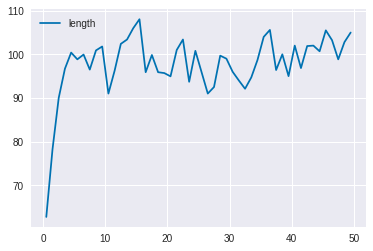

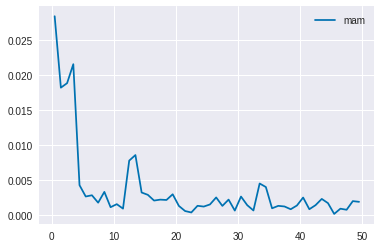

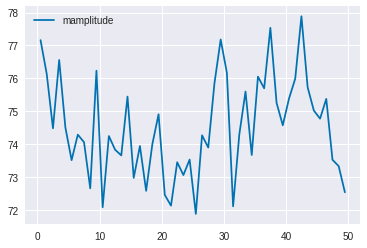

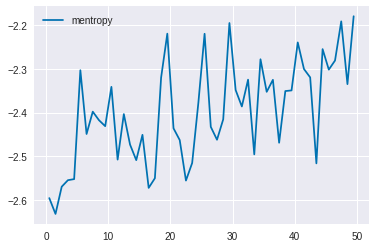

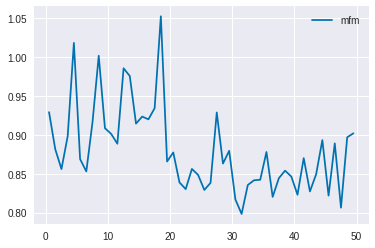

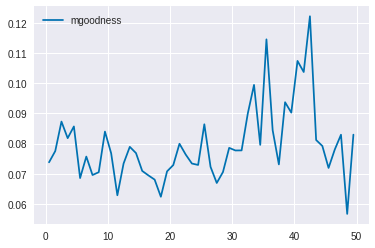

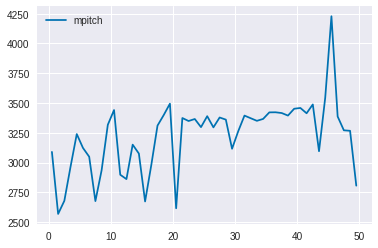

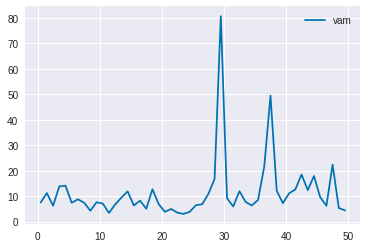

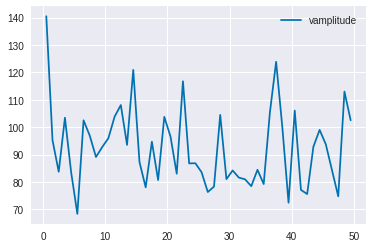

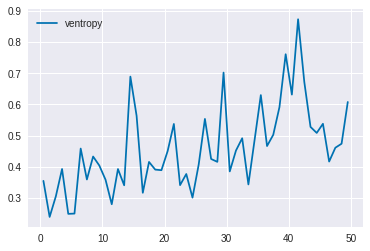

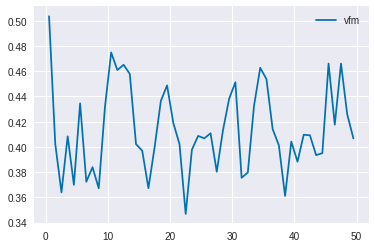

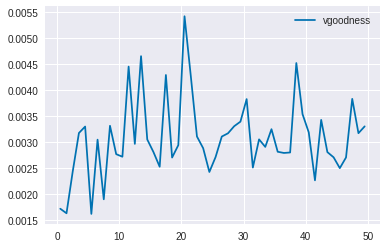

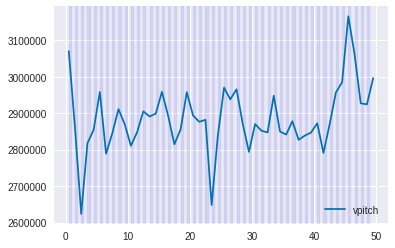

In [7]:
plt.figure(figsize=(14, 14))
med = all_dat.query('beg > {beg} and end < {end} and moment == "evening"'.format(
    beg=tutor_syllables[0]['beg'] - pad,
    end=tutor_syllables[0]['end'] + pad)).groupby('comb').quantile(0.95)
for item in med.keys():
    plt.figure()
    plt.plot(med[item], label=item)
    plt.legend()
for day in range(np.max(all_dat['day'])):
    plt.axvspan(day+0.5, day+1, color='b', alpha=0.1)

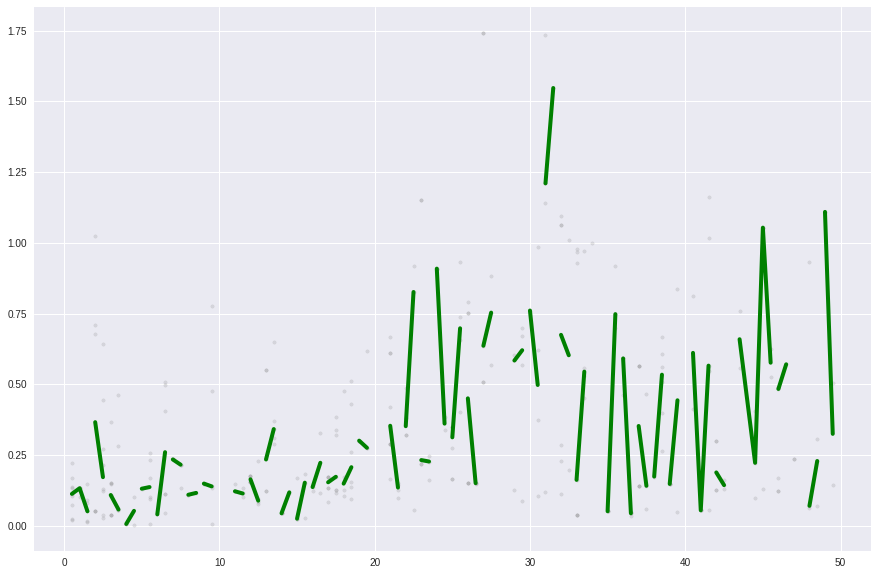

In [8]:
plt.figure(figsize=(15, 10))

feat = 'ventropy'

splitted = all_dat.query("isyb == 3 and div == 15").groupby('comb')[feat].quantile(0.5)
for i in splitted.index:
    if i % 1 == 0:
        splitted.set_value(i + 0.75, np.nan)
splitted.sort_index(inplace=True)


plt.scatter(all_dat.query("isyb == 3 and div == 15")['comb'], all_dat.query("isyb == 3 and div == 15")[feat], marker='.', alpha=0.2, color="grey")
plt.plot(splitted, linewidth=4, color="g")


In [9]:
splitted

comb
0.50     0.112065
1.00     0.132166
1.50     0.050650
1.75          NaN
2.00     0.365770
2.50     0.171206
2.75          NaN
3.00     0.108035
3.50     0.056911
3.75          NaN
4.00     0.005653
4.50     0.052072
4.75          NaN
5.00     0.130391
5.50     0.136151
5.75          NaN
6.00     0.039650
6.50     0.259650
6.75          NaN
7.00     0.233819
7.50     0.215370
7.75          NaN
8.00     0.108972
8.50     0.115524
8.75          NaN
9.00     0.148485
9.50     0.138597
9.75          NaN
11.00    0.121255
11.50    0.113455
           ...   
37.75         NaN
38.00    0.173373
38.50    0.533651
38.75         NaN
39.00    0.147199
39.50    0.443136
39.75         NaN
40.50    0.610823
41.00    0.053924
41.50    0.565690
41.75         NaN
42.00    0.187859
42.50    0.143025
42.75         NaN
43.50    0.659091
44.50    0.221943
45.00    1.053757
45.50    0.576050
45.75         NaN
46.00    0.483246
46.50    0.570292
46.75         NaN
47.00    0.237048
47.75         NaN
48.00

# Percent Change analysis

## Percent change absolute values

## Percent change signed values

In [10]:
all_changes = []

#features = ['mentropy', 'mfm','mgoodness','vfm','ventropy','vgoodness']
features = ['ventropy']

# NIGHT

for bird_n, bird in all_dat.groupby('bird'):
    print(bird_n)
    for isyb, syllable in tutor_df.iterrows():
        print('syb:', isyb)
        beg = syllable['beg'] - pad
        end = syllable['end'] + pad
        objective = bird.query('day == {} and moment == "evening" and beg > {beg} and end < {end}'.format(bird['day'].max()-1, beg=beg, end=end))
        if len(objective) == 0:
            print(isyb, 'ignored')
            continue
        for day in range(bird['day'].max()):
            first = bird.query('day == {} and moment == "evening" and beg > {beg} and end < {end}'.format(day, beg=beg, end=end))
            last  = bird.query('day == {} and moment == "morning" and beg > {beg} and end < {end}'.format(day+1, beg=beg, end=end))
            if len(first) > 0 and len(last) > 0:
                sign = np.sign(last.median() - first.median()) * np.sign(objective.median() - first.median())[features]
                #display(sign)
                percent_change_all = (sign * (((last.median() - first.median()) / first.median().abs() * 100).abs())[features])
                percent_change = percent_change_all.mean()
                    #print(percent_change_all)
                    #print(first['ventropy'])
                    #print(last['ventropy'])
                all_changes.append({'day': day, 'isyb': isyb, 'bird': bird_n, 'div': bird['div'].iloc[0], 'percent_change':percent_change, 'cond': 'night'})

# DAY
for bird_n, bird in all_dat.groupby('bird'):
    print(bird_n)
    for isyb, syllable in tutor_df.iterrows():
        print('syb:', isyb)
        beg = syllable['beg'] - pad
        end = syllable['end'] + pad
        objective = bird.query('day == {} and moment == "evening" and beg > {beg} and end < {end}'.format(bird['day'].max()-1, beg=beg, end=end))
        if len(objective) == 0:
            print(isyb, 'ignored')
            continue
        for day in range(bird['day'].max()):
            first = bird.query('day == {} and moment == "morning" and beg > {beg} and end < {end}'.format(day, beg=beg, end=end))
            last  = bird.query('day == {} and moment == "evening" and beg > {beg} and end < {end}'.format(day, beg=beg, end=end))
            if len(first) > 0 and len(last) > 0:
                sign = np.sign(last.median() - first.median()) * np.sign(objective.median() - first.median())[features]
                #display(sign)
                percent_change_all = (sign * (((last.median() - first.median()) / first.median().abs() * 100).abs())[features])
                percent_change = percent_change_all.mean()
                all_changes.append({'day': day, 'isyb': isyb, 'div': bird['div'].iloc[0], 'bird': bird_n, 'percent_change':percent_change, 'cond': 'day'})


2
syb: 0
syb: 1
syb: 2
3
syb: 0
syb: 1
syb: 2
10
syb: 0
syb: 1
syb: 2
15
syb: 0
syb: 1
syb: 2
1010
syb: 0
syb: 1
syb: 2
4002
syb: 0
syb: 1
syb: 2
4003
syb: 0
syb: 1
syb: 2
4010
syb: 0
syb: 1
syb: 2
4015
syb: 0
syb: 1
syb: 2
9010
syb: 0
syb: 1
syb: 2
10002
syb: 0
syb: 1
syb: 2
10003
syb: 0
syb: 1
syb: 2
10010
syb: 0
syb: 1
syb: 2
10015
syb: 0
syb: 1
syb: 2
2
syb: 0
syb: 1
syb: 2
3
syb: 0
syb: 1
syb: 2
10
syb: 0
syb: 1
syb: 2
15
syb: 0
syb: 1
syb: 2
1010
syb: 0
syb: 1
syb: 2
4002
syb: 0
syb: 1
syb: 2
4003
syb: 0
syb: 1
syb: 2
4010
syb: 0
syb: 1
syb: 2
4015
syb: 0
syb: 1
syb: 2
9010
syb: 0
syb: 1
syb: 2
10002
syb: 0
syb: 1
syb: 2
10003
syb: 0
syb: 1
syb: 2
10010
syb: 0
syb: 1
syb: 2
10015
syb: 0
syb: 1
syb: 2


In [11]:
change_df = pd.DataFrame(all_changes)
change_df["birdsyb"] = change_df['bird'] * 1000 + change_df['isyb']

change_df = change_df.groupby(('day', 'bird', 'cond')).mean()

change_df = pd.DataFrame(change_df.to_records())


In [12]:
change_df.groupby(('day', 'bird', 'cond')).mean()

div  isyb  percent_change     birdsyb
day bird  cond                                         
0   2     day     2.0   0.5    14123.938285      2000.5
          night   2.0   1.0      -50.502722      2001.0
    3     day     3.0   0.5    12282.113575      3000.5
          night   3.0   1.0      -27.370304      3001.0
    10    day    10.0   0.5    11187.369705     10000.5
          night  10.0   1.0       -2.200494     10001.0
    15    day    15.0   0.5     8005.443782     15000.5
          night  15.0   1.0      -15.289305     15001.0
    1010  day    10.0   0.5    55405.712557   1010000.5
          night  10.0   0.5      -55.934861   1010000.5
    4002  day     2.0   0.5     9337.259584   4002000.5
          night   2.0   0.0       53.123911   4002000.0
    4003  day     3.0   0.5     7530.114072   4003000.5
          night   3.0   0.5      -19.090395   4003000.5
    4010  day    10.0   0.5     9362.075242   4010000.5
    4015  day    15.0   0.5     9689.971311   4015000.5
          night  15.0   0.5        8.780273   4015000.5
    9010  day    10.0   0.5     9377.182383   9010000.5
          night  10.0   1.0      -29.867529   9010001.0
    10002 day     2.0   0.5    10023.124496  10002000.5
          night   2.0   1.0       32.867930  10002001.0
    10003 day     3.0   0.5    11391.380971  10003000.5
          night   3.0   1.5      -24.455526  10003001.5
    10010 day    10.0   0.5    10665.264330  10010000.5
          night  10.0   1.0      -21.340841  10010001.0
    10015 day    15.0   0.5    15860.929506  10015000.5
          night  15.0   1.0       14.648641  10015001.0
1   2     day     2.0   1.0       98.260235      2001.0
          night   2.0   1.0      -21.595562      2001.0
    3     day     3.0   1.0       -6.859403      3001.0
...               ...   ...             ...         ...
47  10015 day    15.0   0.5       27.415504  10015000.5
          night  15.0   1.0       63.581915  10015001.0
48  2     day     2.0   1.0       34.041296      2001.0
          night   2.0   1.0        0.000000      2001.0
    3     day     3.0   1.0       28.877933      3001.0
          night   3.0   1.0        0.000000      3001.0
    10    day    10.0   1.0       41.911325     10001.0
          night  10.0   1.0        0.000000     10001.0
    15    day    15.0   1.0       24.626505     15001.0
          night  15.0   0.0        0.000000     15000.0
    1010  day    10.0   1.0      103.139944   1010001.0
          night  10.0   1.0        0.000000   1010001.0
    4002  day     2.0   1.5        5.608384   4002001.5
          night   2.0   1.0        0.000000   4002001.0
    4003  day     3.0   1.0       13.118697   4003001.0
          night   3.0   1.0        0.000000   4003001.0
    4010  day    10.0   1.0       50.617229   4010001.0
          night  10.0   1.0        0.000000   4010001.0
    4015  day    15.0   1.0       33.453537   4015001.0
          night  15.0   1.0        0.000000   4015001.0
    9010  day    10.0   1.0       33.362416   9010001.0
          night  10.0   1.0        0.000000   9010001.0
    10002 day     2.0   1.0      115.812751  10002001.0
          night   2.0   1.0        0.000000  10002001.0
    10003 day     3.0   1.0       19.419513  10003001.0
          night   3.0   1.0        0.000000  10003001.0
    10010 day    10.0   1.0       71.011967  10010001.0
          night  10.0   1.5        0.000000  10010001.5
    10015 day    15.0   1.0        6.878574  10015001.0
          night  15.0   1.0        0.000000  10015001.0

[1343 rows x 4 columns]

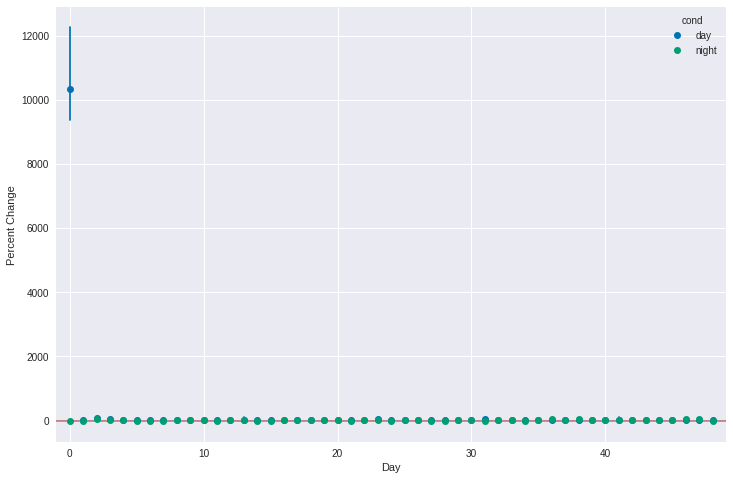

In [13]:
plt.figure(figsize=(12, 8))
plt.axhline(0, c='darkred', alpha=0.5)
sns.tsplot(change_df, time='day', unit='bird', interpolate=False, value='percent_change', condition='cond', err_style='ci_bars', ci=95, estimator=np.nanmedian)
sns.despine()
plt.ylabel("Percent Change")
plt.xlabel('Day')
plt.savefig('per_det.svg')

In [14]:
all_changes_df = pd.DataFrame(all_changes)
night_pc = change_df.query('cond == "night"').groupby('bird').mean()

In [15]:
night_pc

,day,div,isyb,percent_change,birdsyb
bird,,,,,
2,23.282609,2.0,0.880435,26.463746,2.000880e+03
3,24.145833,3.0,0.979167,7.389088,3.000979e+03
10,24.000000,10.0,1.000000,33.646219,1.000100e+04
15,24.000000,15.0,0.908163,11.119401,1.500091e+04
1010,24.434783,10.0,0.836957,28.753948,1.010001e+06
4002,24.437500,2.0,0.895833,27.648494,4.002001e+06
4003,24.000000,3.0,0.877551,24.081836,4.003001e+06
4010,24.500000,10.0,1.000000,13.308247,4.010001e+06
4015,24.000000,15.0,0.928571,34.296467,4.015001e+06


In [16]:
force = True
try:
    sim
except:
    force = True
if force:
    sim = []
    for bird in night_pc.index:
        i = bird//1000
        div = bird%1000
        try:
            with open(join(main_path.format(i, div), 'data_cur.pkl'), 'rb') as f:
                songlog = pickle.load(f)
        except FileNotFoundError:
            continue
        root_data = [item[1] for item in songlog if item[0] == 'root']
        rd = pd.DataFrame(root_data)
        smodels = rd['songs'].iloc[-1]
        print(i, div, 'beg')
        sim.append(bsa.similarity(smodels[np.argmin(rd['scores'].iloc[-1])].gen_sound(), tutor)['similarity'])
        print(i)

0 2 beg
0
0 3 beg
0
0 10 beg
0
0 15 beg
0
1 10 beg
1
4 2 beg
4
4 3 beg
4
4 10 beg
4
4 15 beg
4
9 10 beg
9
10 2 beg
10
10 3 beg
10
10 10 beg
10
10 15 beg
10


In [17]:
night_pc['percent_change_deterioration'] = -night_pc['percent_change']

night_pc['sim'] = sim

(0, 1)

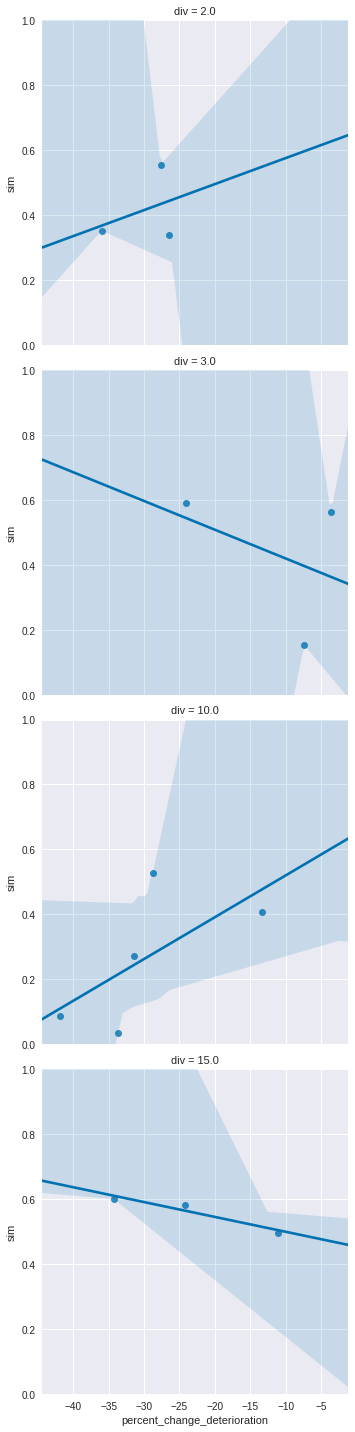

In [18]:

sns.lmplot(x="percent_change_deterioration", y='sim', row='div', data=night_pc, ci=95)
plt.ylim((0, 1))

In [19]:
from scipy import stats

In [20]:
stats.linregress(night_pc['percent_change_deterioration'], night_pc['sim'])

LinregressResult(slope=0.0046304101942046018, intercept=0.51039183952906464, rvalue=0.27250469737343802, pvalue=0.34590339657034053, stderr=0.0047195396975214226)

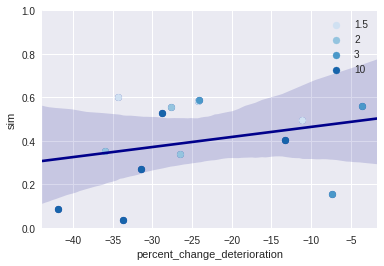

In [21]:
with sns.color_palette('Blues', 4):
    ax = sns.regplot(x="percent_change_deterioration", y='sim', data=night_pc, ci=95, color="darkblue")
    plt.figure(figsize=(8, 8))
    ax.set_ylim((0, 1))
    for i, div in enumerate([15, 2, 3, 10]):
        if div > 10:
            div_s = div / 10
        else:
            div_s = div
        ax.scatter(night_pc.query('div == {}'.format(div))['percent_change_deterioration'], list(night_pc.query('div == {}'.format(div))['sim']), label=div_s)
    ax.legend()